In [14]:
from constants import *
import camera_lib
import matplotlib.pyplot as plt
from ultralytics import YOLO
import clip
import torch
import cv2
from PIL import Image
import math

In [31]:
cam = camera_lib.Camera(0)

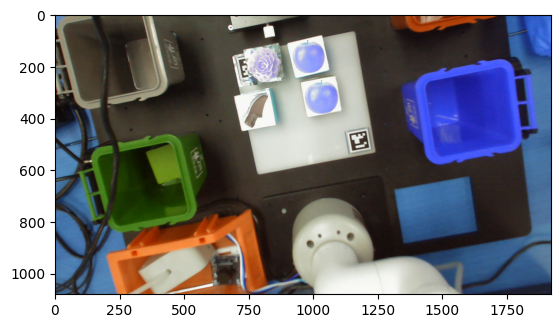

In [147]:
img = cam.capture1920x1080()
plt.figure()
plt.imshow(img)
plt.show()

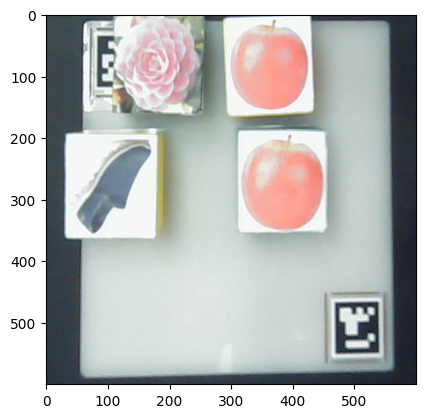

In [148]:
img_cut = camera_lib.cut_image(img)
plt.figure()
plt.imshow(img_cut)
plt.show()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [100]:
yolo = YOLO("../yolov8m-oiv7.pt")
cutted = Image.fromarray(img_cut)


In [101]:
results = yolo(cutted,save=True, conf=0.1)

cutted_np = np.array(cutted)

for r in results:
    box=r.boxes
    cls=box.cls
    conf=box.conf
    xywh=box.xywh
    print(cls,conf,xywh)
    # 边界框坐标

    img_list=[]
    for i in range(0,len(box)): 
        [x, y, w, h] = xywh[i]  # 替换为实际的边界框坐标
        x=math.floor(x)
        y=math.floor(y)
        w=math.floor(w)
        h=math.floor(h)
        # 创建分割图像的掩膜

        # 分割部分的图像
        segmented_image = Image.fromarray(cutted_np[y-h//2:y+h//2, x-w//2:x+w//2])
        img_list.append(segmented_image)
  


0: 640x640 1 Apple, 1 Camera, 1 Food, 1 Rabbit, 548.6ms
Speed: 4.0ms preprocess, 548.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict7
tensor([ 82., 411., 199.,  10.]) tensor([0.8203, 0.4716, 0.4210, 0.1341]) tensor([[423.4152,  92.7099, 141.6294, 153.2832],
        [165.1440, 239.6083, 144.0060, 145.5348],
        [420.3133, 262.8703, 118.3421, 161.6754],
        [ 87.3619,  98.7973, 113.4991, 139.1514]])


In [58]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 82., 203.,  10., 113., 199., 374., 573.])
conf: tensor([0.8699, 0.4874, 0.2644, 0.2063, 0.1967, 0.1608, 0.1494])
data: tensor([[4.1725e+02, 1.8888e+02, 5.5649e+02, 3.4017e+02, 8.6989e-01, 8.2000e+01],
        [4.2609e+02, 2.1076e+01, 5.4995e+02, 1.6883e+02, 4.8744e-01, 2.0300e+02],
        [3.9526e+01, 1.9918e+02, 1.7349e+02, 3.4767e+02, 2.6437e-01, 1.0000e+01],
        [2.2295e+02, 2.5301e+01, 3.5658e+02, 1.7356e+02, 2.0628e-01, 1.1300e+02],
        [4.0901e+01, 3.4602e+01, 1.7988e+02, 1.7193e+02, 1.9667e-01, 1.9900e+02],
        [3.9070e+01, 1.9962e+02, 1.7297e+02, 3.4802e+02, 1.6081e-01, 3.7400e+02],
        [2.2228e+02, 2.4332e+01, 3.5786e+02, 1.7981e+02, 1.4938e-01, 5.7300e+02]])
id: None
is_track: False
orig_shape: (600, 600)
shape: torch.Size([7, 6])
xywh: tensor([[486.8720, 264.5256, 139.2457, 151.2973],
        [488.0236,  94.9538, 123.8582, 147.7556],
        [106.5069, 273.4264, 133.9619, 148.4946],
    

[[     0.2087     0.23566     0.21432     0.20057]]


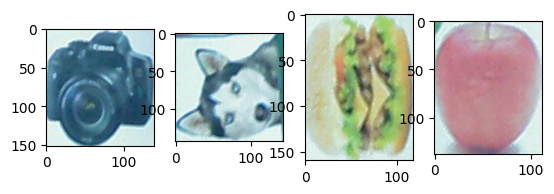

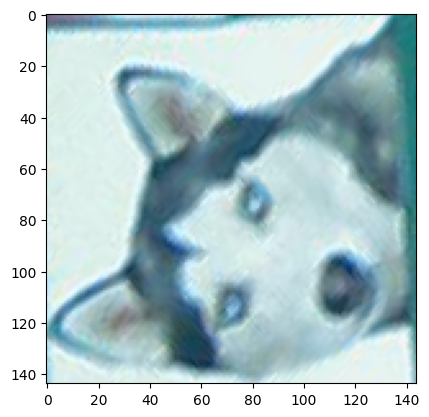

tensor([165.1440, 239.6083])


In [103]:
image_names = ["shoe", "hamburger", "dog"]
original_images = img_list
images = []
query = "select the animal from the scene"
texts = [].append(query)

# for n in image_names:
#     img = Image.open(f"../test/{n}.jpg").convert("RGB")
#     original_images.append(img)

for img in original_images:
    images.append(preprocess(img))

image_input = torch.tensor(np.stack(images))
text_token = clip.tokenize(query)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_token).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = 10

plt.figure()
for id, img in enumerate(original_images):
    plt.subplot(1, len(original_images), id+1)
    plt.imshow(img)
print(similarity)
best = np.argmax(similarity)
plt.figure()
plt.imshow(original_images[best])
plt.show()
xy = results[0].boxes[best].xywh
xy = xy[0,:2]
print(xy)

In [105]:
import RobotArm


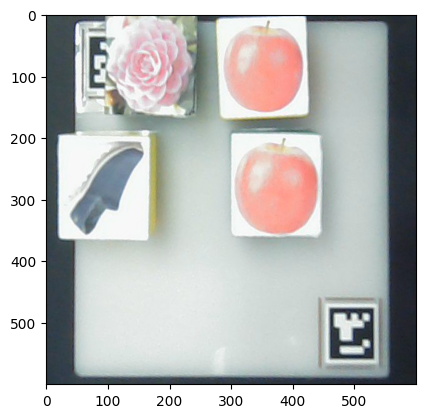


0: 640x640 2 Apples, 1 Rose, 538.0ms
Speed: 6.0ms preprocess, 538.0ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict7
tensor([427.,  10.,  10.]) tensor([0.7554, 0.3227, 0.2185]) tensor([[166.2907,  80.7347, 144.3187, 160.5746],
        [374.0119, 280.3079, 135.4483, 153.3009],
        [352.3015,  87.5114, 130.1363, 143.0317]])
[[    0.23271     0.19007     0.19555]]


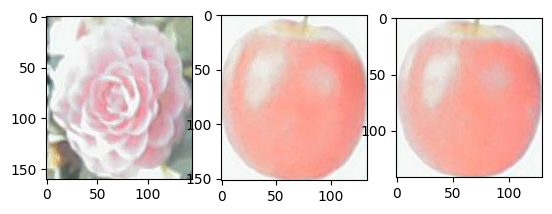

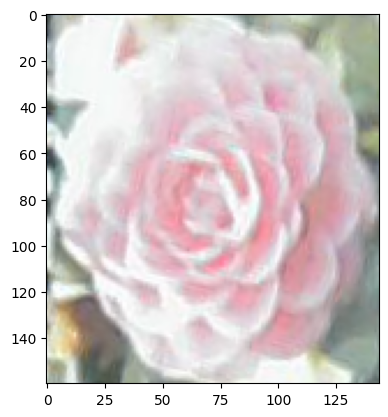

tensor([166.2907,  80.7347])


SerialException: WriteFile failed (PermissionError(13, '拒绝访问。', None, 5))

In [149]:
img = cam.capture1920x1080()
img_cut = camera_lib.cut_image(img)
plt.figure()
plt.imshow(img_cut)
plt.show()
cutted = Image.fromarray(img_cut)
results = yolo(cutted,save=True, conf=0.1)

cutted_np = np.array(cutted)
tmp_box = []
for r in results:
    box=r.boxes
    cls=box.cls
    conf=box.conf
    xywh=box.xywh
    print(cls,conf,xywh)
    # 边界框坐标

    img_list=[]
    for i in range(0,len(box)): 
        [x, y, w, h] = xywh[i]  # 替换为实际的边界框坐标
        x=math.floor(x)
        y=math.floor(y)
        w=math.floor(w)
        h=math.floor(h)
        # 创建分割图像的掩膜
        if w > 200 or h > 200:
            continue
        tmp_box.append(xywh[i])
        # 分割部分的图像
        segmented_image = Image.fromarray(cutted_np[y-h//2:y+h//2, x-w//2:x+w//2])
        img_list.append(segmented_image)

original_images = img_list
images = []

query = f"{input()}"

texts = [].append(query)

# for n in image_names:
#     img = Image.open(f"../test/{n}.jpg").convert("RGB")
#     original_images.append(img)

for img in original_images:
    images.append(preprocess(img))

image_input = torch.tensor(np.stack(images))
text_token = clip.tokenize(query)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_token).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

plt.figure()
for id, img in enumerate(original_images):
    plt.subplot(1, len(original_images), id+1)
    plt.imshow(img)
print(similarity)
best = np.argmax(similarity)
plt.figure()
plt.imshow(original_images[best])
plt.show()
xy = tmp_box[best]
xy = xy[:2]
print(xy)
RobotArm.move(xy[0], xy[1],120, 170)

In [137]:
hdg = Image.open("../test/hundgun.jpg").convert("RGB")
yolo(hdg, save=True, conf=0.1)

0: 384x640 1 Camera, 403.6ms
Speed: 5.3ms preprocess, 403.6ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict7


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Accordion', 1: 'Adhesive tape', 2: 'Aircraft', 3: 'Airplane', 4: 'Alarm clock', 5: 'Alpaca', 6: 'Ambulance', 7: 'Animal', 8: 'Ant', 9: 'Antelope', 10: 'Apple', 11: 'Armadillo', 12: 'Artichoke', 13: 'Auto part', 14: 'Axe', 15: 'Backpack', 16: 'Bagel', 17: 'Baked goods', 18: 'Balance beam', 19: 'Ball', 20: 'Balloon', 21: 'Banana', 22: 'Band-aid', 23: 'Banjo', 24: 'Barge', 25: 'Barrel', 26: 'Baseball bat', 27: 'Baseball glove', 28: 'Bat (Animal)', 29: 'Bathroom accessory', 30: 'Bathroom cabinet', 31: 'Bathtub', 32: 'Beaker', 33: 'Bear', 34: 'Bed', 35: 'Bee', 36: 'Beehive', 37: 'Beer', 38: 'Beetle', 39: 'Bell pepper', 40: 'Belt', 41: 'Bench', 42: 'Bicycle', 43: 'Bicycle helmet', 44: 'Bicycle wheel', 45: 'Bidet', 46: 'Billboard', 47: 'Billiard table', 48: 'Binoculars', 49: 'Bird', 50: 'Blender', 51: 'Blue jay', 52: 'Boat', 53: 'Bomb', 54: '